# 04 - Teacher Model Testing

## Objectives
1. Load and test the teacher model `google/flan-t5-xl`
2. Verify soft logits (probabilities) generation
3. Test teacher inference on NLI examples
4. Verify teacher-student integration for distillation

## Distillation Flow
```
Dataset → Teacher Model → Soft Logits (probabilities)
       ↘                ↗
         Student Model
``` 
```       
Loss = α·CE(student, labels) + β·KL(student||teacher)
```

In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn.functional as F

# Check device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.10.0+cu128


## 1. Loading the Teacher Model

Loading FLAN-T5-XL as the teacher model. The model has ~3B parameters.

In [2]:
from src.models.teacher import FlanT5Teacher, TeacherConfig

# Teacher configuration
teacher_config = TeacherConfig(
    model_name="google/flan-t5-xl", # Large teacher model for maximum knowledge distillation
    device=device, 
    use_fp16=True if device == "cuda" else False
)

print("Loading teacher model...")
print(f"Model: {teacher_config.model_name}")
print(f"Device: {teacher_config.device}")
print(f"FP16: {teacher_config.use_fp16}")

Loading teacher model...
Model: google/flan-t5-xl
Device: cuda
FP16: True


In [3]:
# Carica il teacher model
teacher = FlanT5Teacher(teacher_config) # Initialize the teacher model

print(f"\nTeacher model loaded!")
print(f"Parameters: {teacher.count_parameters():,}")

INFO:src.models.teacher:Initializing teacher model: google/flan-t5-xl
INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/config.json "HTTP/1.1 200 OK"


config.json: 0.00B [00:00, ?B/s]

INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/main/model.safetensors "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/main/model.safetensors.index.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/model.safetensors.index.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/model.safetensors.index.json "HTTP/1.1 200 OK"


model.safetensors.index.json: 0.00B [00:00, ?B/s]

INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/google/flan-t5-xl/revision/main "HTTP/1.1 200 OK"


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/7d6315df2c2fb742f0f5b556879d730926ca9001/model-00001-of-00002.safetensors "HTTP/1.1 302 Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/7d6315df2c2fb742f0f5b556879d730926ca9001/model-00002-of-00002.safetensors "HTTP/1.1 302 Found"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/google/flan-t5-xl/xet-read-token/7d6315df2c2fb742f0f5b556879d730926ca9001 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/google/flan-t5-xl/xet-read-token/7d6315df2c2fb742f0f5b556879d730926ca9001 "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/558 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/generation_config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/generation_config.json "HTTP/1.1 200 OK"


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/tokenizer_config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/tokenizer_config.json "HTTP/1.1 200 OK"


tokenizer_config.json: 0.00B [00:00, ?B/s]

INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/google/flan-t5-xl/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/google/flan-t5-xl/tree/main?recursive=true&expand=false "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/main/spiece.model "HTTP/1.1 302 Found"


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/main/tokenizer.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/tokenizer.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/tokenizer.json "HTTP/1.1 200 OK"


tokenizer.json: 0.00B [00:00, ?B/s]

INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/main/added_tokens.json "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/main/special_tokens_map.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/special_tokens_map.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/resolve-cache/models/google/flan-t5-xl/7d6315df2c2fb742f0f5b556879d730926ca9001/special_tokens_map.json "HTTP/1.1 200 OK"


special_tokens_map.json: 0.00B [00:00, ?B/s]

INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-xl/resolve/main/chat_template.jinja "HTTP/1.1 404 Not Found"
INFO:src.models.teacher:Teacher model loaded on cuda with dtype torch.float16
INFO:src.models.teacher:Teacher parameters: 2,849,757,184 (frozen)



Teacher model loaded!
Parameters: 2,849,757,184


## 2. Inference Testing of the Teacher

Testing the teacher on some NLI examples to verify it works correctly.

In [4]:
# Examples of NLI test cases
test_examples = [
    {
        "premise": "A man is playing guitar on stage.",
        "hypothesis": "A person is performing music.",
        "expected_label": "entailment"
    },
    {
        "premise": "The cat is sleeping on the couch.",
        "hypothesis": "The cat is running outside.",
        "expected_label": "contradiction"
    },
    {
        "premise": "Children are playing in the park.",
        "hypothesis": "The children are wearing hats.",
        "expected_label": "neutral"
    }
]

# Format as NLI prompt
def format_nli_prompt(premise, hypothesis):
    return f"Premise: {premise}\nHypothesis: {hypothesis}\nDoes the premise entail, contradict, or is neutral to the hypothesis? Explain your reasoning."

for ex in test_examples:
    prompt = format_nli_prompt(ex["premise"], ex["hypothesis"])
    print(f"Prompt: {prompt[:100]}...")
    print(f"Expected: {ex['expected_label']}")
    print("-" * 50)

Prompt: Premise: A man is playing guitar on stage.
Hypothesis: A person is performing music.
Does the premis...
Expected: entailment
--------------------------------------------------
Prompt: Premise: The cat is sleeping on the couch.
Hypothesis: The cat is running outside.
Does the premise ...
Expected: contradiction
--------------------------------------------------
Prompt: Premise: Children are playing in the park.
Hypothesis: The children are wearing hats.
Does the premi...
Expected: neutral
--------------------------------------------------


In [5]:
# Generalization test with the teacher model
tokenizer = teacher.tokenizer

for i, ex in enumerate(test_examples):
    prompt = format_nli_prompt(ex["premise"], ex["hypothesis"])
    
    # Input tokenization
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=512,
        truncation=True,
        padding=True
    ).to(device)
    
    # Answer generation
    outputs = teacher.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=128
    )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    print(f"\n=== Example {i+1} ===")
    print(f"Premise: {ex['premise']}")
    print(f"Hypothesis: {ex['hypothesis']}")
    print(f"Expected: {ex['expected_label']}")
    print(f"Teacher response: {response}")


=== Example 1 ===
Premise: A man is playing guitar on stage.
Hypothesis: A person is performing music.
Expected: entailment
Teacher response: A man is a person and playing a guitar is a form of performing music. Therefore, the answer is yes.

=== Example 2 ===
Premise: The cat is sleeping on the couch.
Hypothesis: The cat is running outside.
Expected: contradiction
Teacher response: contradictory The cat cannot be sleeping and running at the same time. Therefore, the answer is contradictory.

=== Example 3 ===
Premise: Children are playing in the park.
Hypothesis: The children are wearing hats.
Expected: neutral
Teacher response: It is not stated that the children are wearing hats. Therefore, the answer is it is not possible to tell.


## 3. Soft Logits of the Teacher

Verify the generation of soft logits (probability distributions) that the student will have to imitate.

In [6]:
# Test soft logits
ex = test_examples[0]
prompt = format_nli_prompt(ex["premise"], ex["hypothesis"])
target = "entailment. The man playing guitar is performing music."

# Tokenizza input e target
inputs = tokenizer(
    prompt,
    return_tensors="pt",
    max_length=512,
    truncation=True,
    padding=True
).to(device)

targets = tokenizer(
    target,
    return_tensors="pt",
    max_length=128,
    truncation=True,
    padding=True
).to(device)

# Prepare decoder_input_ids (shift right for teacher forcing)
decoder_input_ids = targets["input_ids"].clone()
decoder_input_ids[:, 1:] = targets["input_ids"][:, :-1].clone()
decoder_input_ids[:, 0] = tokenizer.pad_token_id

print(f"Input shape: {inputs['input_ids'].shape}")
print(f"Decoder input shape: {decoder_input_ids.shape}")

Input shape: torch.Size([1, 42])
Decoder input shape: torch.Size([1, 14])


In [7]:
# Obtain soft logits from the teacher
with torch.no_grad():
    teacher_outputs = teacher(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        decoder_input_ids=decoder_input_ids
    )

teacher_logits = teacher_outputs["logits"]
print(f"Teacher logits shape: {teacher_logits.shape}")
print(f"Vocabulary size: {teacher_logits.size(-1)}")

Teacher logits shape: torch.Size([1, 14, 32128])
Vocabulary size: 32128


In [8]:
# Convert logits into soft probabilities
temperature = 2.0  # Temperature for soft labels
soft_probs = F.softmax(teacher_logits / temperature, dim=-1)

print(f"Soft probabilities shape: {soft_probs.shape}")
print(f"\nFor the first token:")
print(f"  Max probability: {soft_probs[0, 0].max().item():.4f}")
print(f"  Min probability: {soft_probs[0, 0].min().item():.6f}")
print(f"  Top-5 token indices: {soft_probs[0, 0].topk(5).indices.tolist()}")

# Decode top-5 tokens
top5_tokens = soft_probs[0, 0].topk(5)
print(f"\nTop-5 tokens with probabilities:")
for idx, prob in zip(top5_tokens.indices, top5_tokens.values):
    token = tokenizer.decode([idx.item()])
    print(f"  '{token}': {prob.item():.4f}")

Soft probabilities shape: torch.Size([1, 14, 32128])

For the first token:
  Max probability: 0.0489
  Min probability: 0.000000
  Top-5 token indices: [71, 37, 2163, 94, 2911]

Top-5 tokens with probabilities:
  'A': 0.0489
  'The': 0.0338
  'Yes': 0.0283
  'It': 0.0282
  'Play': 0.0141


## 4. Compare Teacher vs Student

Let's compare the probability distributions between the teacher and the student.

In [9]:
from src.models.student import StudentModel, StudentConfig

# Load student model
student_config = StudentConfig(
    model_name="google/flan-t5-base", # Smaller student model for faster training and inference
    device=device
)

student = StudentModel(student_config)
print(f"\nStudent model loaded!")
print(f"Parameters student: {student.count_parameters():,}")
print(f"Parameters teacher: {teacher.count_parameters():,}")
print(f"Ratio: {teacher.count_parameters() / student.count_parameters():.1f}x")

INFO:src.models.student:Initializing student model: google/flan-t5-base
INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/google/flan-t5-base/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-base/resolve/main/model.safetensors "HTTP/1.1 302 Found"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/google/flan-t5-base/xet-read-token/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2 "HTTP/1.1 200 OK"


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-base/resolve/main/generation_config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/google/flan-t5-base/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/generation_config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/resolve-cache/models/google/flan-t5-base/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/generation_config.json "HTTP/1.1 200 OK"


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/google/flan-t5-base/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/google/flan-t5-base/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/google/flan-t5-base/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/tokenizer_config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/google/flan-t5-base/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/google/flan-t5-base/tree/main?recursive=true&expand=false "HTTP/1.1 200 OK"
The following generation flags are not valid and may be ignored: [


Student model loaded!
Parameters student: 247,577,856
Parameters teacher: 2,849,757,184
Ratio: 11.5x


In [10]:
# Obtain logits from the student
student.model.eval()
with torch.no_grad():
    student_outputs = student(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        labels=targets["input_ids"]
    )

student_logits = student_outputs["logits"]
print(f"Student logits shape: {student_logits.shape}")
print(f"Teacher logits shape: {teacher_logits.shape}")

Student logits shape: torch.Size([1, 14, 32128])
Teacher logits shape: torch.Size([1, 14, 32128])


In [11]:
# Compute KL divergence between student and teacher
T = 2.0  # Temperature

# Soft probabilities
student_soft = F.log_softmax(student_logits / T, dim=-1)
teacher_soft = F.softmax(teacher_logits / T, dim=-1)

# Align vocabulary size if necessary
if student_soft.size(-1) != teacher_soft.size(-1):
    min_vocab = min(student_soft.size(-1), teacher_soft.size(-1))
    student_soft = student_soft[:, :, :min_vocab]
    teacher_soft = teacher_soft[:, :, :min_vocab]

# KL divergence
kl_div = F.kl_div(student_soft, teacher_soft, reduction='batchmean')
print(f"KL Divergence (student || teacher): {kl_div.item():.4f}")

# With temperature scaling
kl_div_scaled = kl_div * (T ** 2)
print(f"KL Divergence scaled (T²): {kl_div_scaled.item():.4f}")

KL Divergence (student || teacher): 4.7388
KL Divergence scaled (T²): 18.9552


## 5. Visualize Distributions

Let's visualize the probability distributions of the teacher and student.

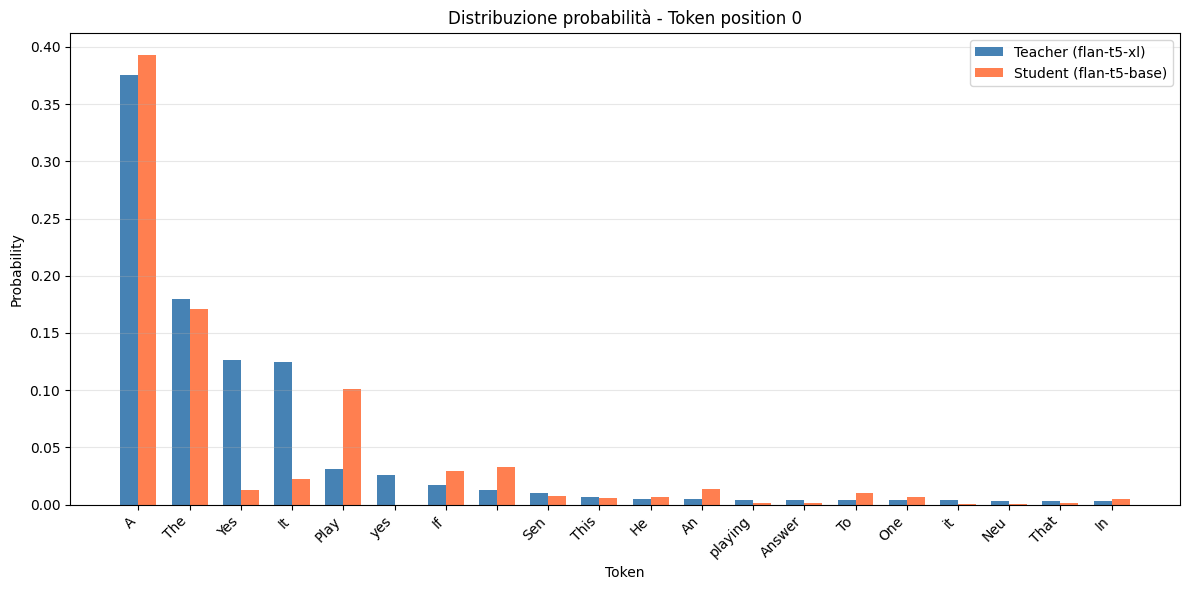

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Take a specific token position to compare probabilities (here the first token) between teacher and student
token_idx = 0
top_k = 20

teacher_probs = F.softmax(teacher_logits[0, token_idx], dim=-1)
student_probs = F.softmax(student_logits[0, token_idx], dim=-1)

# Top-k tokens from the teacher
top_teacher = teacher_probs.topk(top_k)
top_indices = top_teacher.indices.cpu().numpy()

# Get the same probabilities from the student
teacher_top_probs = top_teacher.values.cpu().numpy()
student_top_probs = student_probs[top_indices].cpu().numpy()

# Token names
token_names = [tokenizer.decode([idx]) for idx in top_indices]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(token_names))
width = 0.35

bars1 = ax.bar(x - width/2, teacher_top_probs, width, label='Teacher (flan-t5-xl)', color='steelblue')
bars2 = ax.bar(x + width/2, student_top_probs, width, label='Student (flan-t5-base)', color='coral')

ax.set_xlabel('Token')
ax.set_ylabel('Probability')
ax.set_title(f'Distribuzione probabilità - Token position {token_idx}')
ax.set_xticks(x)
ax.set_xticklabels(token_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Memory Usage

Evaluate memory usage for training with distillation.

In [13]:
if device == "cuda":
    print("=== GPU Memory Usage ===")
    print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    print(f"Max Allocated: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")
else:
    print(f"Running on {device} - GPU memory stats not available")
    
# Estimate memory usage based on parameter count and precision
teacher_mem_gb = teacher.count_parameters() * 2 / 1e9  # FP16
student_mem_gb = student.count_parameters() * 4 / 1e9  # FP32

print(f"\n=== Model Memory Estimates ===")
print(f"Teacher ({teacher_config.model_name}): ~{teacher_mem_gb:.1f} GB (FP16)")
print(f"Student ({student_config.model_name}): ~{student_mem_gb:.1f} GB (FP32)")
print(f"Total Estimated: ~{teacher_mem_gb + student_mem_gb:.1f} GB")

=== GPU Memory Usage ===
Allocated: 7.71 GB
Cached: 8.11 GB
Max Allocated: 7.72 GB

=== Model Memory Estimates ===
Teacher (google/flan-t5-xl): ~5.7 GB (FP16)
Student (google/flan-t5-base): ~1.0 GB (FP32)
Total Estimated: ~6.7 GB


## 7. Riepilogo

Il teacher model è pronto per la knowledge distillation!

In [14]:
print("=" * 60)
print("SUMMARY - TEACHER MODEL TESTING")
print("=" * 60)
print(f"\nTeacher Model: {teacher_config.model_name}")
print(f"  - Parameters: {teacher.count_parameters():,}")
print(f"  - Device: {device}")
print(f"  - FP16: {teacher_config.use_fp16}")
print(f"\nStudent Model: {student_config.model_name}")
print(f"  - Parameters: {student.count_parameters():,}")
print(f"  - Compression ratio: {teacher.count_parameters() / student.count_parameters():.1f}x")
print("\n" + "=" * 60)
print("=" * 60)

SUMMARY - TEACHER MODEL TESTING

Teacher Model: google/flan-t5-xl
  - Parameters: 2,849,757,184
  - Device: cuda
  - FP16: True

Student Model: google/flan-t5-base
  - Parameters: 247,577,856
  - Compression ratio: 11.5x

